# Breastfeeding survey analysis

This notebook analyses the survey responses to Jessica Barton's breastfeeding questionnaire.

Items

  - Summarize population (number screened, criteria, >= 18 years old, Morena usage positive or negative)
  - Within population, summarize demographic factors (age, race, ethnicity, education, income, marital status), exposure, covariates, and outcome
  - Exposure: Morena usage
  - Covariates:
    - Hormonal issues (how defined?)
    - Difficulty conceiving
    - Age of baby at start of birth control (Morena?)
    - Age of mother
    - Mother overweight
  - Outcome: milk supply went down
  
  - Describe unadjusted "rate" of outcome for each birth control type
  - Describe "rate" adjusted for covariates for each birth control type?

## Setup and read in the data

In [1]:
import sqlite3
import numpy as np
import pandas as pd
from pandas.io.sql import read_sql_query

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn = sqlite3.connect('../data/analysis.sqlite3')
curs = conn.cursor()
curs.execute("attach database '../data/codes.sqlite3' as codes;")

population_query = '''
    select RespondentId, sex, age_yc, bf_status, age_mother, AP, AP_reason
    from survey
'''

population = read_sql_query(population_query, conn)
survey = read_sql_query('select * from survey where AP = 1', conn)

In [3]:
population.head()

,RespondentID,sex,age_yc,bf_status,age_mother,AP,AP_reason
0,2503542169,2,2.0,NaN,NaN,0,2
1,2503602344,2,1.0,1.0,29.0,1,0
2,2503604232,2,1.0,1.0,32.0,1,0
3,2503605645,2,1.0,1.0,32.0,1,0
4,2503606246,2,1.0,1.0,32.0,1,0


## Summarize enrollment

In [4]:
read_sql_query('''
    select 0 as Code, 'Total screened' as Description, count(*) as n
    from survey
        union all
    select a.Code, a.Description, count(*) as n
    from codes.AP_reason as a
        inner join survey as s
            on a.Code = s.AP_reason
    group by a.Code, a.Description
    order by 1
''', conn).set_index(['Code', 'Description'])

,,n
Code,Description,
0,Total screened,4688
1,Respondent was male,8
2,Youngest child older than 18 months,391
3,Youngest child weaned more than 18 months ago,7
4,Youngest child never breastfed,10
5,Respondent not confirmed 18 years or older,540


Based on the above, 4,688 attempted with survey, with 8 being excluded for being male, 391 for not having a young enough child, 7 for having weaned too long ago, 10 for never having breastfed their youngest child, and 540 for being too young (or not having clean enough data to show how old they were).

The age restriction is a bit conservative. As we only collected birth year and all of the surveys were completed in 2013, age was computed as the smallest possible age (that is, as age before birthday in 2013).

### Quick summary of body mass index within the population

This is a little different from the analysis that Frances already ran. Not sure why, since we're looking at the same data...

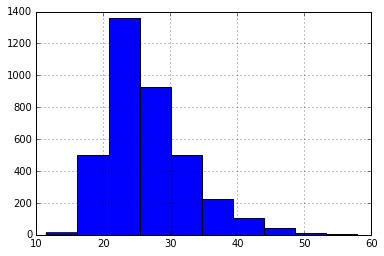

In [5]:
survey.bmi.hist()

In [6]:
bmi_table = read_sql_query('''
    select b.Code, b.Description, count(*) as n
    from survey as s
        left join codes.bmi_category as b
            on s.bmi_category = b.Code
    where s.AP = 1
    group by b.Code, b.Description
    order by 1
''', conn).set_index(['Code', 'Description'])

bmi_table['%'] = bmi_table.n / bmi_table.n.sum() * 100
bmi_table

,,n,%
Code,Description,,
NaN,NaN,43,1.152197
1.0,Underweight,111,2.974277
2.0,Normal weight,1659,44.453376
3.0,Overweight,1020,27.331190
4.0,Obese,899,24.088960
